<font size = 5> **The psychometric function: FItting, sampling and goodness of fit** </font>


link - https://link-springer-com.udel.idm.oclc.org/article/10.3758/BF03194544

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import stats
import scipy.optimize as opt

In [2]:
def sym_psycho(x, prob, n_trials):
    #list to append respond rate
    response_rate = []
    
    for i in range(len(x)):
        #append responses at each stimuli
        responses = []
        
        for n in range(n_trials):
            
            response = np.random.choice([0, 1], p = [1 - prob[i], prob[i]])
            responses.append(response)
        
        response_rate.append(np.sum(responses)/n_trials)
        
    
    return response_rate  


def nloglik(paras, I, C):

    #calculate the Probability of each point using mean and sigma
    P = 1/2 + (1/2) * stats.norm.cdf(I, paras[0], paras[1])
    
    #nll
    nll = -np.sum(C * np.log(P) + (1 - C) * np.log(1 - P))
    
        
    return nll

def nloglike(paras, I, C):

    #calculate the Probability of each point using mean and sigma
    if (paras[2] < 0.06) and paras[2] > 0:
        P = 1/2 + (1 - 1/2 - paras[2]) * stats.norm.cdf(I, paras[0], paras[1])
    else:
        P = 1/2 + (1 - 1/2) * stats.norm.cdf(I, paras[0], paras[1])
        
    #nll
    nll = -np.sum(C * np.log(P) + (1 - C) * np.log(1 - P))
    
        
    return nll

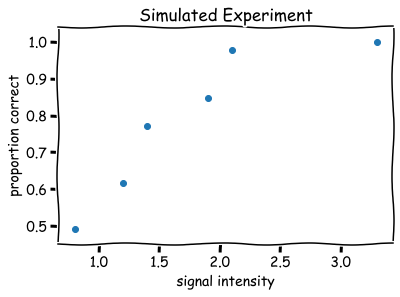

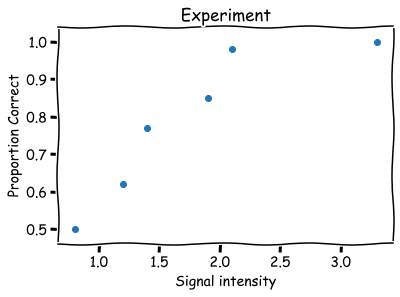

In [3]:
x = np.array([0.8, 1.2, 1.4, 1.9, 2.1, 3.3])
prob = np.array([0.5, 0.62, 0.77, 0.85, 0.98, 1])

responses = sym_psycho(x, prob, 1000)

#simulated experiment
plt.xkcd()
plt.figure()
plt.title('Simulated Experiment')
plt.xlabel('signal intensity')
plt.ylabel('proportion correct')
plt.scatter(x, responses)
plt.show()

#exact values
plt.figure()
plt.title('Experiment')
plt.xlabel('Signal intensity')
plt.ylabel('Proportion Correct')
plt.scatter(x, prob)
plt.show()

In [7]:
#fit for the psychometric function above
x_data = np.array([0.8, 1.2, 1.4, 1.9, 2.1, 3.3])
prob_data = np.array([0.5, 0.62, 0.77, 0.85, 1, 0.97])
results1 = opt.fmin(nloglike, x0 = [2,2,0], args = (x_data, prob_data), disp = False)


#psychometric function
def interact(mu = 1.5, sigma = 1, gamma = 0.5, lam = 0, error = 0):
    
    plt.figure(figsize = (12, 7))
    
    x = np.arange(0, 3.3, 0.01)
    y = gamma + (1 - gamma - lam) * stats.norm.cdf(x, mu, sigma)
       
    x_data = np.array([0.8, 1.2, 1.4, 1.9, 2.1, 3.3])
    
    if error == 0:
        prob_data = np.array([0.5, 0.62, 0.77, 0.85, 1, 1])
        results = opt.fmin(nloglik, x0 = [2,2], args = (x_data, prob_data), disp = False)
        results1 = opt.fmin(nloglike, x0 = [2,2,0], args = (x_data, prob_data), disp = False)
    elif error == 1:
        prob_data = np.array([0.5, 0.62, 0.77, 0.85, 1, 0.96])
        results = opt.fmin(nloglik, x0 = [2,2], args = (x_data, prob_data), disp = False)
        results1 = opt.fmin(nloglike, x0 = [2,2,0], args = (x_data, prob_data), disp = False)
      
    #psychometric fit using mle
    y_mle = 0.5 + 0.5 * stats.norm.cdf(x, results[0], results[1]) #lambda fixed
    y_mle_lam = 0.5 + (1 - 0.5 - results1[2]) * stats.norm.cdf(x, results1[0], results1[1]) #lamda free
      
    #plt.plot(x, y, color = 'r')
    plt.scatter(x_data, prob_data, marker = 's', color = 'k', s = 100, label = 'SUBJECT DATA')
    plt.plot(x, y_mle, linewidth = 10, color = 'b', alpha = 0.3, label = 'MLE FIT - Lambda fixed')
    plt.plot(x, y_mle_lam, linestyle = '--', label = 'MLE FIT - Lambda free')
    plt.scatter(3.3, 0.96, marker = '<', s = 120, label = 'Lapse')
    plt.title('Pychometric function')
    plt.ylabel('Proportion correct')
    plt.xlabel('Angular Difference')
    plt.legend()
    
_ = widgets.interact(interact, mu = (0.1,3, 0.025), sigma = (0.01, 4.01, 0.025), gamma = (0, 1, 0.01), lam = (0.01, 1, 0.01),
                     error = (0,1))

interactive(children=(FloatSlider(value=1.5, description='mu', max=3.0, min=0.1, step=0.025), FloatSlider(valu…

In [5]:
#print the results 
print('The mean is: ', results1[0])
print('The variance is: ', results1[1])
print('The lambda is: ', results1[2])

The mean is:  1.4400837474964905
The variance is:  0.40684802329115344
The lambda is:  0.022462066091087175


In [6]:
#do the monte carlo simulations
def prob(x):
    y = 0.5 + (1 - 0.5 - results1[2]) * stats.norm.cdf(x, results1[0], results1[1])
    return y

#intensities
X = np.array([0.8, 1.2, 1.4, 1.9, 2.1, 3.3])

#number of simulations 
B = 10**4

#number of trials at each x intensity
n = 50

#number of intensities(stimuli)
K = len(X)

#Deviance values
D = []

#probabilities
P = []

for b in range(B):
    
    #probabilities
    PP = []
    DD = []
       
    for k in range(K):
        
        #get intensity
        x = X[k]
        
        #find the probability corresponding to that intensity using the cumalitive gaussian
        y = prob(x)
        
        #list to append responses
        responses = []
        
        for nn in range(n):
            
            #generate responses 1 or 0 with probability of that intensity 
            response = np.random.choice([1, 0], p = [y, 1 - y])
            responses.append(response)
        
        #calculate the proprotion correct
        PP.append(np.sum(responses)/len(responses))
        
    P.append(PP)
    
    #calculating the deviance
    d = 0
    for i in range(K):
        
        #y_i
        yi = prob(X[i])
        
        #p_i
        pi = PP[i]
        
        #if pi == 0:
            #print(pi)
        
        d += n * yi * np.log(yi/pi) + n * (1 - yi) * np.log( (1 - yi) / (1 - pi) )
    
    D.append(2*d)

C:\Users\kanee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


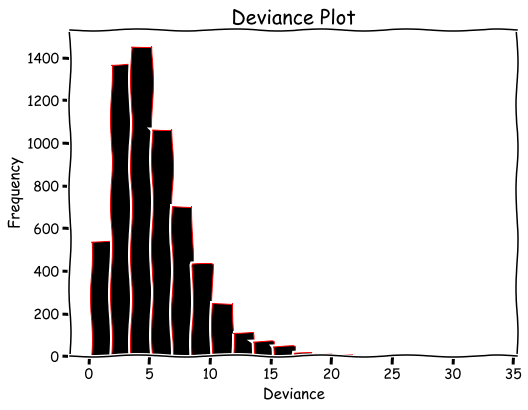

In [8]:
#Get rid of inf values. Couldn't fix this 
Dev = np.array([D])
Dev = Dev[Dev < 1E308]

#histogram of deviance
plt.figure(figsize = (8,6))
plt.title('Deviance Plot', fontsize = 20)
plt.hist(Dev, bins = 20, color = 'k', edgecolor = 'r')
plt.xlabel('Deviance', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.show()

In [8]:
x = np.array([0.8, 1.2, 1.4, 1.9, 2.1, 3.3])
p = np.array([0.5, 0.62, 0.77, 0.85, 1, 0.97])

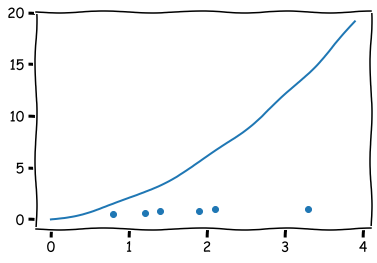

In [12]:
plt.scatter(x, p)
plt.plot(xx, y)